In [2]:
import pandas as pd
import numpy as np
import missingno as msn
import gc

## 1. CO2 data

In [2]:
environment_data = pd.read_csv('raw_data/environment_data.csv', low_memory=False)

In [3]:
# identifier on gvkey and time is fiscal year to merge with financial data,
col = ['gvkey', 'companytype', 'fiscalyear', 'simpleindustry', 'di_319407', 'di_319408', 'di_319409', 'di_319522', 'yearfounded']
co2_data = environment_data[col]
co2_data.columns = ['gvkey', 'companytype', 'fyear', 'industry', 'Intensity_scope1', 'Intensity_scope2', 'Intensity_scope3', 'revenue', 'yearfounded']

co2_data['Co2_scope1'] = co2_data.Intensity_scope1 * co2_data.revenue
co2_data['Co2_scope2'] = co2_data.Intensity_scope2 * co2_data.revenue
co2_data['Co2_scope3'] = co2_data.Intensity_scope3 * co2_data.revenue

# sort by values
co2_data = co2_data.sort_values(['gvkey', 'fyear'])

# co2 emission growth
co2_data['Co2_scope1GR'] = co2_data.groupby('gvkey')['Co2_scope1'].pct_change()
co2_data['Co2_scope2GR'] = co2_data.groupby('gvkey')['Co2_scope2'].pct_change()
co2_data['Co2_scope3GR'] = co2_data.groupby('gvkey')['Co2_scope3'].pct_change()

# co2 intensity growth
co2_data['Intensity_scope1GR'] = co2_data.groupby('gvkey')['Intensity_scope1'].pct_change()
co2_data['Intensity_scope2GR'] = co2_data.groupby('gvkey')['Intensity_scope2'].pct_change()
co2_data['Intensity_scope3GR'] = co2_data.groupby('gvkey')['Intensity_scope3'].pct_change()

# co2 total
co2_data['Co2_tot'] = co2_data.Co2_scope1.fillna(0) + co2_data.Co2_scope2.fillna(0) + co2_data.Co2_scope3.fillna(0)
co2_data['Intensity_tot'] = co2_data.Intensity_scope1.fillna(0) + co2_data.Intensity_scope2.fillna(0) + co2_data.Intensity_scope3.fillna(0)
# co2 total change
co2_data['Co2_totalGR'] = co2_data.groupby('gvkey')['Co2_tot'].pct_change()
co2_data['Intensity_totGR'] = co2_data.groupby('gvkey')['Intensity_tot'].pct_change()

# sales growth
co2_data['SaleGR'] = co2_data.groupby('gvkey')['revenue'].pct_change()

C:\Users\wangc\AppData\Local\Temp\ipykernel_8692\3303614415.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  co2_data['Co2_scope1'] = co2_data.Intensity_scope1 * co2_data.revenue
C:\Users\wangc\AppData\Local\Temp\ipykernel_8692\3303614415.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  co2_data['Co2_scope2'] = co2_data.Intensity_scope2 * co2_data.revenue
C:\Users\wangc\AppData\Local\Temp\ipykernel_8692\3303614415.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

## 2. Financial data

In [4]:
finance_data = pd.read_csv('raw_data/finance_data.csv', low_memory=False)

In [5]:
col = ['gvkey', 'fyear', 'at', 'ppegt', 'emp', 'cogs', 'capx', 'lt', 'sale', 'csho', 'ceq', 'ib', 'epspx', 'ni', 'xint', 'dp', 'txt']
finance_data_reduced = finance_data[col]

# all are in millions of dollars

# at: Assets - Total
# ppegt: Property, Plant and Equipment - Total (Gross)
# emp: number of employees
# cogs: Cost of Goods Sold
# capx: Capital Expenditures
# lt: Liabilities - Total
# sale: Sales/Turnover Net, revenue
# csho: common share outstanding in thousands
# ceq: Common/Ordinary Equity - Total
# ib: Income Before Extraordinary Items
# epspx: Earnings Per Share (Basic)/Excluding Extraordinary Items
# ni: Net Income (Loss)
# xint: Interest and Related Expense - Total
# dp: Depreciation and Amortization
# txt: Income Taxes - Total

## 3. Merge CO2 and Finance data

In [6]:
del[environment_data, finance_data]
gc.collect()

0

In [7]:
# merged on gvkey and fyear
co2_finance = pd.merge(co2_data, finance_data_reduced, how='right')
# choose only publicly treded companies
co2_finance = co2_finance[co2_finance.companytype == 'Public Company']

## 4. Stock data

In [8]:
del[co2_data, finance_data_reduced]
gc.collect()

0

In [9]:
# load monthly price data from CRSP
stock_data = pd.read_csv('raw_data/monthly_stock_CRSP.csv')

# convert date to year_month format
stock_data['date'] = pd.to_datetime(stock_data['date'])
stock_data['year_month'] = stock_data['date'].dt.to_period('M')

# choose data from date since 2002
stock_data = stock_data[stock_data.year_month > '2001-12']
stock_data = stock_data.sort_values(['PERMNO', 'year_month']).reset_index(drop=True)

# replace missing return with nan
stock_data['RET'] = stock_data['RET'].replace({'C': np.nan, 'B': np.nan})
stock_data['RET'] = stock_data['RET'].astype(float)
stock_data['PRC'] = np.abs(stock_data.PRC)

# select variables 
stock_data = stock_data[['PERMNO', 'year_month', 'RET', 'PRC']]

## 5. Merge stock data

In [10]:
link_table = pd.read_csv('raw_data/link_table.csv', low_memory=False)

link_table = link_table[['gvkey', 'LPERMNO']]
link_table.columns = ['gvkey', 'PERMNO']

In [11]:
# merge link table to stock price data on Permno
stock_data = stock_data.merge(link_table)

# merge stock data with co2_finance data on GVKEY and year
stock_data['year'] = stock_data.year_month.dt.year
data = stock_data.merge(co2_finance, left_on=['gvkey', 'year'], right_on=['gvkey', 'fyear'], how='left')

In [12]:
data = data.dropna(subset=['PERMNO', 'Intensity_scope1'], how='any')

In [13]:
# sort data
data = data.sort_values(['PERMNO', 'fyear'])

# Construct control variables
# 1. size (log later)
data['Marketcap'] = data.csho * data.PRC
# 2. Leverage
data['Levarage'] = data['lt'] / data['at']
# 3. B/M book to market ratio
data['B/M'] = data.ceq / data.Marketcap
# 4. RoE
data['RoE'] = data.ni / data.ceq
# 5. Investment/total asset
data['Inves/AT'] = data.capx / data['at']
# 6. PPE (log later)
data['PPE'] = data.ppegt
# 7. SaleGR
data['SaleGR'] = data.SaleGR
# 8. EPS
data['EPS'] = data.epspx
# 9. Stuff_num (log later)
data['Staff_num'] = data.emp
# 10. Firm_age (log later)
data['Firm_age'] = 2023 - data.yearfounded

In [14]:
# construct dependent variables
# 1. RoE
# 2. RoA
data['RoA'] = data.ni / data['at']
# 3. RoS
data['RoS'] = data.ni / data.revenue
# 4. EBITMrgpct
data['EBITMrgpct'] = (data.ni.fillna(0) + data.xint.fillna(0) + data.txt.fillna(0)) / data['revenue']
# 5. EBITDAMrgpct
data['EBITDAMrgpct'] = (data.ni.fillna(0) + data.xint.fillna(0) + data.txt.fillna(0) + data.dp.fillna(0)) / data['revenue']

In [15]:
data = data[['PERMNO', 'year_month', 'year', 'fyear', 'industry', 'RET', 'Co2_tot', 'Intensity_tot', 'Co2_scope1', 'Co2_scope2', 'Co2_scope3', 'Intensity_scope1', 'Intensity_scope2', 'Intensity_scope3', 'Co2_totalGR', 'Intensity_totGR', 'Co2_scope1GR', 'Co2_scope2GR', 'Co2_scope3GR', 'Intensity_scope1GR', 'Intensity_scope2GR', 'Intensity_scope3GR', 'Marketcap', 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age', 'RoA', 'RoS', 'EBITMrgpct', 'EBITDAMrgpct']]

<Axes: >

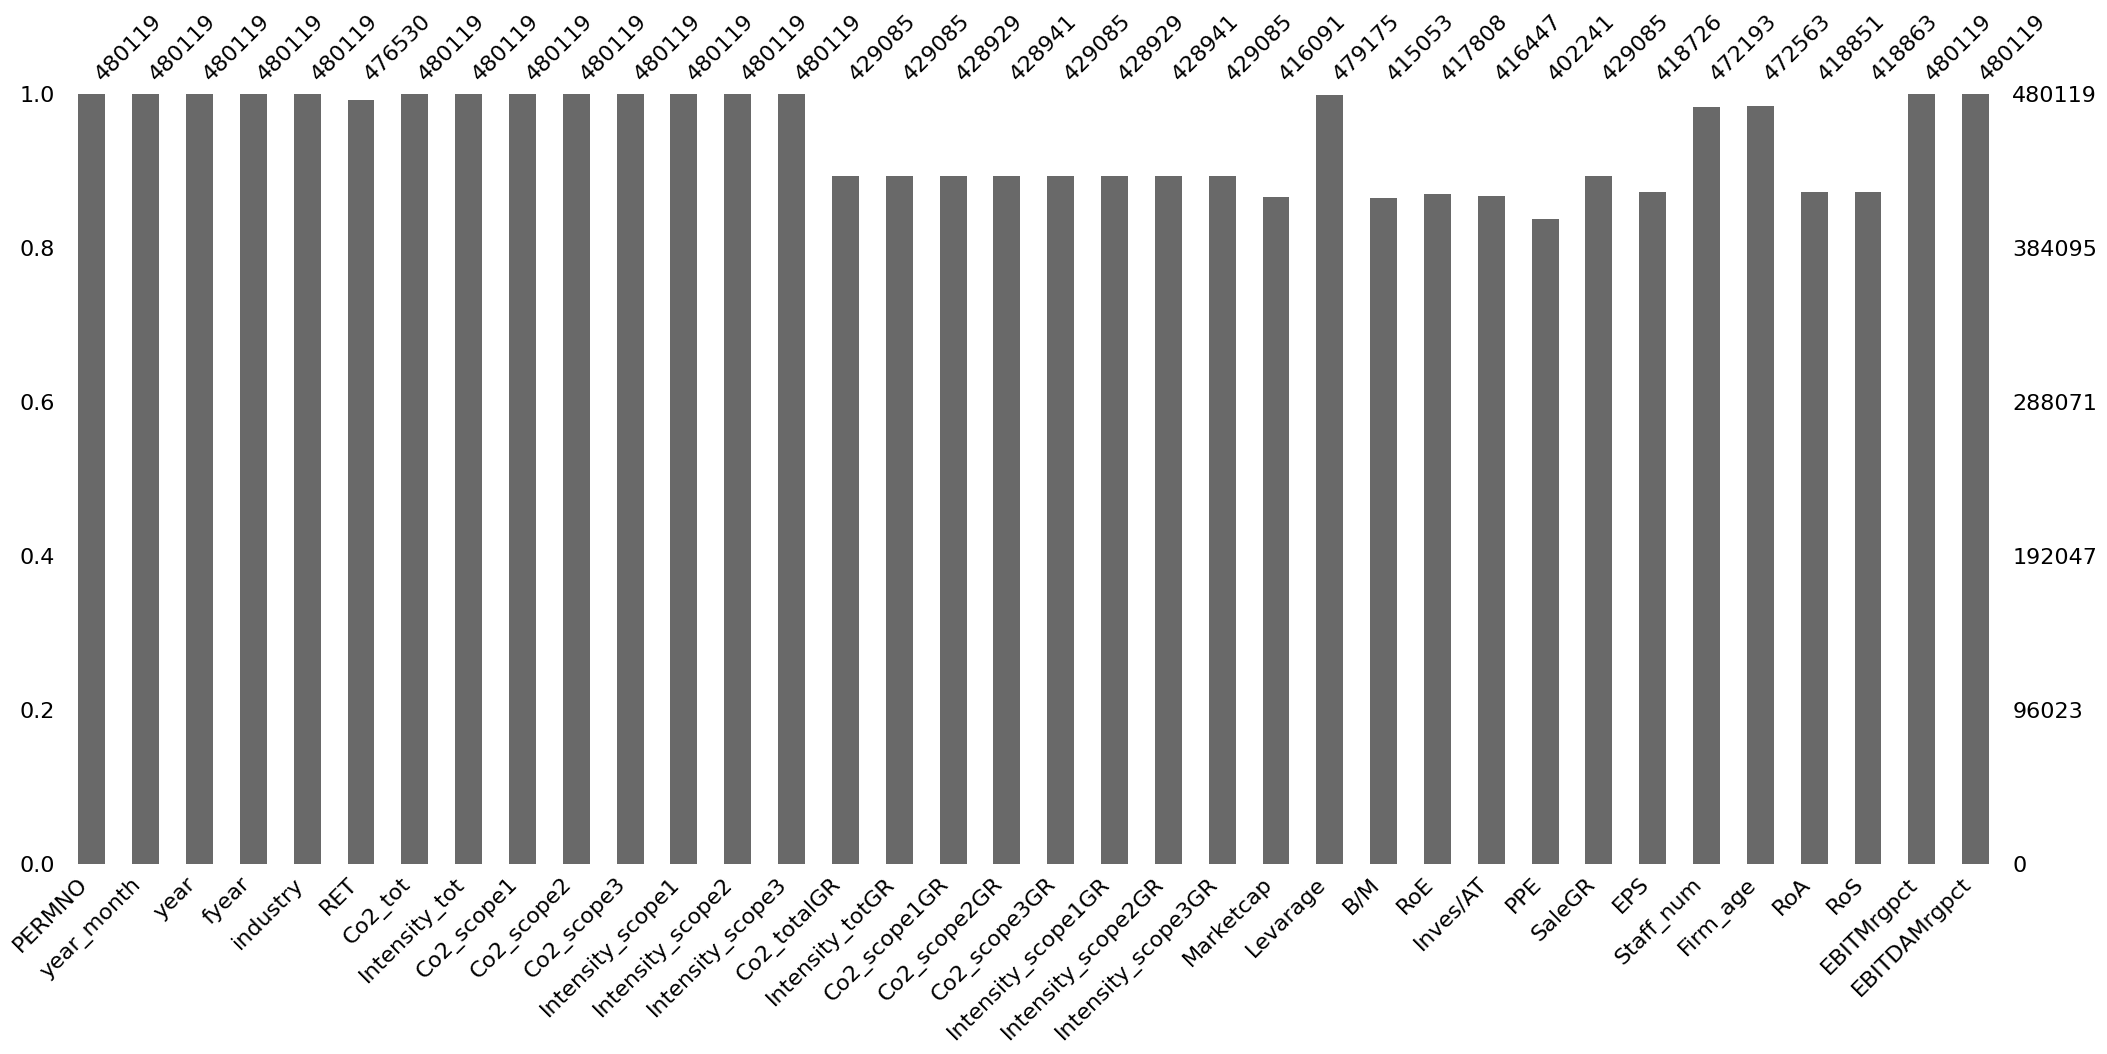

In [16]:
msn.bar(data)

In [17]:
# replace invalid values with nas
data = data.replace([np.inf, -np.inf], np.nan)

In [18]:
# save data to later use
data.to_csv('data.csv', index=False)

## 6. Data exploring

In [31]:
data = pd.read_csv('data.csv')

In [32]:
data.Co2_tot.mean()

5681383.5527446885

In [39]:
data.Co2_tot.min()

0.2677972

In [38]:
data.Co2_tot.describe()

count    4.801190e+05
mean     5.681384e+06
std      2.280588e+07
min      2.677972e-01
25%      5.185498e+04
50%      3.818493e+05
75%      1.915855e+06
max      4.144484e+08
Name: Co2_tot, dtype: float64

In [41]:
data = data[(data.year > 2001) & (data.year < 2022)]
num_companies = data.PERMNO.nunique()
num_obs = data.shape[0]
print('The number of companies is %d' %num_companies)
print('The number of observations is %d' %num_obs)
co2_min = data.Co2_tot.min()
co2_max = data.Co2_tot.max()
co2_mean = data.Co2_tot.mean()
print('Co2 min is %f,'% co2_min, 'Co2 max is %d,'% co2_max, 'Co2_mean is %d'%co2_mean)

The number of companies is 3938
The number of observations is 480119
Co2 min is 0.267797, Co2 max is 414448413, Co2_mean is 5681383


In [13]:
data['RET'] = data['RET']*100

data['Co2_tot'] = np.log(data.Co2_tot + 1)
data['Co2_scope1'] = np.log(data.Co2_scope1 + 1)
data['Co2_scope2'] = np.log(data.Co2_scope2 + 1)
data['Co2_scope3'] = np.log(data.Co2_scope3 + 1)

data['Intensity_tot'] = np.log(data.Intensity_tot + 1)
data['Intensity_scope1'] = np.log(data.Intensity_scope1 + 1)
data['Intensity_scope2'] = np.log(data.Intensity_scope2 + 1)
data['Intensity_scope3'] = np.log(data.Intensity_scope3 + 1)

data['Size'] = np.log(data.Marketcap + 1)
data['PPE'] = np.log(data.PPE + 1)
data['Staff_num'] = np.log(data.Staff_num + 1)
data['Firm_age'] = np.log(data.Firm_age + 1)

### 6.1 Dependent data

In [14]:
np.round(data[['RET', 'RoE', 'RoA', 'RoS', 'EBITMrgpct', 'EBITDAMrgpct']].describe(), 3)

,RET,RoE,RoA,RoS,EBITMrgpct,EBITDAMrgpct
count,476530.000,417808.000,418851.000,418863.000,480119.000,480119.000
mean,1.358,-1.747,0.011,-5.122,-4.314,-4.152
std,14.478,241.377,0.206,136.362,126.924,124.858
min,-92.056,-31837.000,-13.717,-15843.182,-15826.818,-15592.727
25%,-4.532,0.022,0.005,0.012,0.041,0.079
50%,1.023,0.105,0.034,0.069,0.121,0.175
75%,6.488,0.188,0.076,0.144,0.232,0.316
max,1625.053,388.700,5.582,365.618,408.742,412.052


In [15]:
# there are extrem values in some variables hence we winsorize the data
two_way_winsorize = ['RET', 'RoE', 'RoS', 'EBITMrgpct', 'EBITDAMrgpct']
quantiles = data.quantile([0.01, 0.99], numeric_only=True) # calculate quantiles for each column
for col in two_way_winsorize:
  data.loc[(data[col] < quantiles[col].loc[0.01]) | (data[col] > quantiles[col].loc[0.99]), col] = np.nan # replace outliers with np.nan

In [16]:
# summary statistics after winsorizing
np.round(data[['RET', 'RoE', 'RoS', 'EBITMrgpct', 'EBITDAMrgpct']].describe(), 3)

,RET,RoE,RoS,EBITMrgpct,EBITDAMrgpct
count,466999.000,409460.000,410494.000,470528.000,470528.000
mean,1.116,0.066,-0.117,0.011,0.082
std,9.913,0.397,1.314,0.998,0.969
min,-31.596,-3.324,-22.454,-16.266,-15.823
25%,-4.382,0.024,0.014,0.043,0.081
50%,1.023,0.105,0.069,0.121,0.175
75%,6.347,0.185,0.141,0.229,0.312
max,40.095,2.590,0.582,1.167,1.245


### 6.2 CO2 emission data

In [17]:
np.round(data[['Co2_tot', 'Intensity_tot', 'Co2_scope1', 'Co2_scope2', 'Co2_scope3', 'Intensity_scope1', 'Intensity_scope2', 'Intensity_scope3', 'Co2_totalGR', 'Intensity_totGR', 'Co2_scope1GR', 'Co2_scope2GR', 'Co2_scope3GR', 'Intensity_scope1GR', 'Intensity_scope2GR', 'Intensity_scope3GR']].describe(), 3)

,Co2_tot,Intensity_tot,Co2_scope1,Co2_scope2,Co2_scope3,Intensity_scope1,Intensity_scope2,Intensity_scope3,Co2_totalGR,Intensity_totGR,Co2_scope1GR,Co2_scope2GR,Co2_scope3GR,Intensity_scope1GR,Intensity_scope2GR,Intensity_scope3GR
count,480119.000,480119.000,480119.000,480119.000,480119.000,480119.000,480119.000,480119.000,429085.000,429085.000,428869.000,428869.000,429085.000,428869.000,428869.000,429085.000
mean,12.643,4.994,10.134,10.216,12.141,2.775,2.718,4.496,3.422,0.024,3.806,14.491,2.989,0.112,0.902,-0.005
std,2.764,1.321,3.373,2.750,2.596,2.054,1.263,1.013,172.224,3.247,196.877,848.891,143.758,4.582,47.987,0.280
min,0.237,3.065,0.000,0.000,0.175,0.000,0.000,2.968,-1.000,-0.975,-1.000,-1.000,-1.000,-1.000,-1.000,-0.939
25%,10.856,3.779,7.825,8.593,10.456,0.853,1.881,3.502,-0.054,-0.066,-0.078,-0.076,-0.054,-0.081,-0.087,-0.065
50%,12.853,4.859,10.098,10.472,12.377,2.584,2.744,4.448,0.037,-0.021,0.026,0.031,0.041,-0.026,-0.026,-0.016
75%,14.466,5.910,12.312,12.104,13.909,3.627,3.564,5.316,0.161,0.037,0.160,0.188,0.168,0.017,0.057,0.042
max,19.842,11.407,19.782,18.979,19.251,10.360,11.406,8.021,13760.424,665.273,16920.953,77076.649,10745.105,535.260,4927.006,17.390


In [18]:
two_way_winsorize = ['Co2_totalGR', 'Intensity_totGR', 'Co2_scope1GR', 'Co2_scope2GR', 'Co2_scope3GR', 'Intensity_scope1GR', 'Intensity_scope2GR']
quantiles = data.quantile([0.01, 0.99], numeric_only=True) # calculate quantiles for each column
for col in two_way_winsorize:
  data.loc[(data[col] < quantiles[col].loc[0.01]) | (data[col] > quantiles[col].loc[0.99]), col] = np.nan # replace outliers with np.nan

In [19]:
np.round(data[['Co2_tot', 'Intensity_tot', 'Co2_scope1', 'Co2_scope2', 'Co2_scope3', 'Intensity_scope1', 'Intensity_scope2', 'Intensity_scope3', 'Co2_totalGR', 'Intensity_totGR', 'Co2_scope1GR', 'Co2_scope2GR', 'Co2_scope3GR', 'Intensity_scope1GR', 'Intensity_scope2GR', 'Intensity_scope3GR']].describe(), 3)

,Co2_tot,Intensity_tot,Co2_scope1,Co2_scope2,Co2_scope3,Intensity_scope1,Intensity_scope2,Intensity_scope3,Co2_totalGR,Intensity_totGR,Co2_scope1GR,Co2_scope2GR,Co2_scope3GR,Intensity_scope1GR,Intensity_scope2GR,Intensity_scope3GR
count,480119.000,480119.000,480119.000,480119.000,480119.000,480119.000,480119.000,480119.000,420516.000,420510.000,420306.000,420302.000,420525.000,420353.000,420321.000,429085.000
mean,12.643,4.994,10.134,10.216,12.141,2.775,2.718,4.496,0.090,-0.013,0.099,0.141,0.088,-0.010,0.016,-0.005
std,2.764,1.321,3.373,2.750,2.596,2.054,1.263,1.013,0.317,0.109,0.479,0.607,0.299,0.266,0.320,0.280
min,0.237,3.065,0.000,0.000,0.175,0.000,0.000,2.968,-0.642,-0.422,-0.878,-0.803,-0.624,-0.836,-0.764,-0.939
25%,10.856,3.779,7.825,8.593,10.456,0.853,1.881,3.502,-0.052,-0.065,-0.075,-0.073,-0.052,-0.080,-0.085,-0.065
50%,12.853,4.859,10.098,10.472,12.377,2.584,2.744,4.448,0.037,-0.021,0.026,0.031,0.041,-0.026,-0.026,-0.016
75%,14.466,5.910,12.312,12.104,13.909,3.627,3.564,5.316,0.157,0.036,0.155,0.183,0.164,0.015,0.057,0.042
max,19.842,11.407,19.782,18.979,19.251,10.360,11.406,8.021,2.860,0.740,5.110,7.903,2.590,2.338,3.510,17.390


### 6.3 Control variables

In [20]:
np.round(data[['Size', 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].describe(), 3)

,Size,Levarage,B/M,RoE,Inves/AT,PPE,SaleGR,EPS,Staff_num,Firm_age
count,416091.000,479175.000,415053.000,409460.000,416447.000,402241.000,429085.000,418726.000,472193.000,472563.000
mean,8.300,0.641,2.253,0.066,0.042,7.040,2.796,6.955,2.212,4.078
std,1.869,0.269,303.547,0.397,0.052,2.542,133.807,169.647,1.519,0.799
min,0.008,0.001,-4127.450,-3.324,-0.186,0.000,-1.000,-998.260,0.000,1.099
25%,7.083,0.470,0.231,0.024,0.009,5.543,-0.020,0.180,0.877,3.466
50%,8.291,0.644,0.432,0.105,0.026,7.240,0.063,1.580,2.100,4.127
75%,9.559,0.848,0.729,0.185,0.056,8.839,0.174,3.240,3.319,4.779
max,20.722,6.925,128970.128,2.590,0.869,13.362,9944.997,8548.000,7.741,6.489


In [21]:
two_way_winsorize = ['B/M', 'SaleGR', 'EPS']
quantiles = data.quantile([0.01, 0.99], numeric_only=True) # calculate quantiles for each column
for col in two_way_winsorize:
  data.loc[(data[col] < quantiles[col].loc[0.01]) | (data[col] > quantiles[col].loc[0.99]), col] = np.nan # replace outliers with np.nan

In [22]:
np.round(data[['Size', 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].describe(), 3)

,Size,Levarage,B/M,RoE,Inves/AT,PPE,SaleGR,EPS,Staff_num,Firm_age
count,416091.000,479175.000,406753.000,409460.000,416447.000,402241.000,420518.000,410364.000,472193.000,472563.000
mean,8.300,0.641,0.529,0.066,0.042,7.040,0.103,1.918,2.212,4.078
std,1.869,0.269,0.429,0.397,0.052,2.542,0.275,3.146,1.519,0.799
min,0.008,0.001,-0.384,-3.324,-0.186,0.000,-0.591,-9.400,0.000,1.099
25%,7.083,0.470,0.235,0.024,0.009,5.543,-0.017,0.210,0.877,3.466
50%,8.291,0.644,0.432,0.105,0.026,7.240,0.063,1.580,2.100,4.127
75%,9.559,0.848,0.721,0.185,0.056,8.839,0.170,3.190,3.319,4.779
max,20.722,6.925,2.972,2.590,0.869,13.362,2.423,19.820,7.741,6.489


In [28]:
# output summary statistic table
np.round(data[['RET', 'Co2_tot', 'Intensity_tot', 'Size', 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].describe(), 3).T[['count','mean', 'std', 'min', '50%', 'max']].to_latex('summary_statistics.tex', float_format="{:.3f}".format)

C:\Users\wangc\AppData\Local\Temp\ipykernel_5384\3653668658.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  np.round(data[['RET', 'Co2_tot', 'Intensity_tot', 'Size', 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].describe(), 3).T[['count','mean', 'std', 'min', '50%', 'max']].to_latex('summary_statistics.tex', float_format="{:.3f}".format)


In [30]:
# compute the pearson corr among each variables, with statistic significance

# define a function to compute the correlation 
from scipy.stats import pearsonr
def correlation_(df):
  rho = df.corr()
  pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
  p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
  tab = rho.round(2).astype(str) + p
  for i in range(0,tab.shape[1]):
    for j in range(0,tab.shape[1]):
      if i>j:
        tab.iloc[i,j] = ''
  return tab

tab = correlation_(data[['Co2_tot', 'Intensity_tot', 'Size', 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']])
tab.style.to_latex('corr.tex')
tab

,Co2_tot,Intensity_tot,Size,Levarage,B/M,RoE,Inves/AT,PPE,SaleGR,EPS,Staff_num,Firm_age
Co2_tot,1.0***,0.63***,0.68***,-0.0,0.02***,0.24***,0.25***,0.84***,-0.09***,0.3***,0.74***,0.31***
Intensity_tot,,1.0***,0.09***,-0.26***,-0.01***,0.02***,0.37***,0.45***,-0.03***,-0.01***,0.15***,0.01***
Size,,,1.0***,0.05***,-0.21***,0.24***,0.06***,0.71***,0.01**,0.38***,0.73***,0.3***
Levarage,,,,1.0***,-0.02***,0.06***,-0.11***,0.14***,-0.09***,0.05***,0.12***,0.24***
B/M,,,,,1.0***,-0.08***,-0.04***,0.12***,-0.12***,-0.07***,-0.04***,0.05***
RoE,,,,,,1.0***,0.03***,0.2***,0.03***,0.39***,0.2***,0.19***
Inves/AT,,,,,,,1.0***,0.32***,0.06***,0.01***,0.05***,-0.05***
PPE,,,,,,,,1.0***,-0.11***,0.28***,0.71***,0.36***
SaleGR,,,,,,,,,1.0***,0.05***,-0.12***,-0.17***
EPS,,,,,,,,,,1.0***,0.29***,0.24***


In [30]:
# save winsorized data
data.to_csv('data_win.csv', index=False)